Selección e ingieneria de variables

Cargamos las paqueterías necesarias

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


E importamos las herramientas a utilizar

In [215]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


Establecemos el path de la base de datos

In [216]:
# Define the file path
file_path = '../data/Processed/preprocessed_data.csv'

Y cargamos la base de datos, y visualizamos rapido de las variables

In [217]:
# Read the CSV file
data = pd.read_csv(open(file_path))

# Display the first few rows of the dataframe
print(data.head())

   Id  MSSubClass  LotFrontage  LotArea  Alley  OverallQual  OverallCond  \
0   1          60         65.0     8450      0            7            5   
1   2          20         80.0     9600      0            6            8   
2   3          60         68.0    11250      0            7            5   
3   4          70         60.0     9550      0            7            5   
4   5          60         84.0    14260      0            8            5   

   YearBuilt  YearRemodAdd  MasVnrType  ...  SaleType_ConLI  SaleType_ConLw  \
0       2003          2003           1  ...           False           False   
1       1976          1976           0  ...           False           False   
2       2001          2002           1  ...           False           False   
3       1915          1970           0  ...           False           False   
4       2000          2000           1  ...           False           False   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  \

Verificamos la forma del abase de datos despues de la lnmpieza y los encoder

In [218]:
print(data.shape)  # Devuelve (n_filas, n_columnas)

(1460, 194)


Calculamos la matrpiz de correlacciones, y mostramos las correlacciones con la vrariable de interes, Saleprice

In [219]:
# Calcular correlaciones
correlation_matrix = data.corr(numeric_only=True)  # Excluye variables categóricas
saleprice_corr = correlation_matrix["SalePrice"].sort_values(ascending=False)

# Mostrar las más correlacionadas
print(saleprice_corr)

SalePrice            1.000000
OverallQual          0.790982
GrLivArea            0.708624
ExterQual            0.682639
KitchenQual          0.659600
                       ...   
LotShape_Reg        -0.267672
MSZoning_RM         -0.288065
GarageFinish        -0.292483
Foundation_CBlock   -0.343263
GarageType                NaN
Name: SalePrice, Length: 194, dtype: float64


Como son muchas, nos fijaremos en aquellas que tengan una correlaccion mayor a 0.30

In [220]:
high_corr_vars = saleprice_corr[abs(saleprice_corr) > 0.3]

# Mostrar las variables filtradas
print(high_corr_vars)

SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
ExterQual                0.682639
KitchenQual              0.659600
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
BsmtQual                 0.585207
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
FireplaceQu              0.520438
YearRemodAdd             0.507101
Foundation_PConc         0.497734
MasVnrArea               0.472614
Fireplaces               0.466929
HeatingQC                0.427649
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
MasVnrType               0.379400
BsmtExposure             0.374696
SaleType_New             0.357509
SaleCondition_Partial    0.352060
Neighborhood_NoRidge     0.330424
WoodDeckSF               0.324413
2ndFlrSF                 0.319334
OpenPorchSF              0.315856
Exterior2nd_Vi

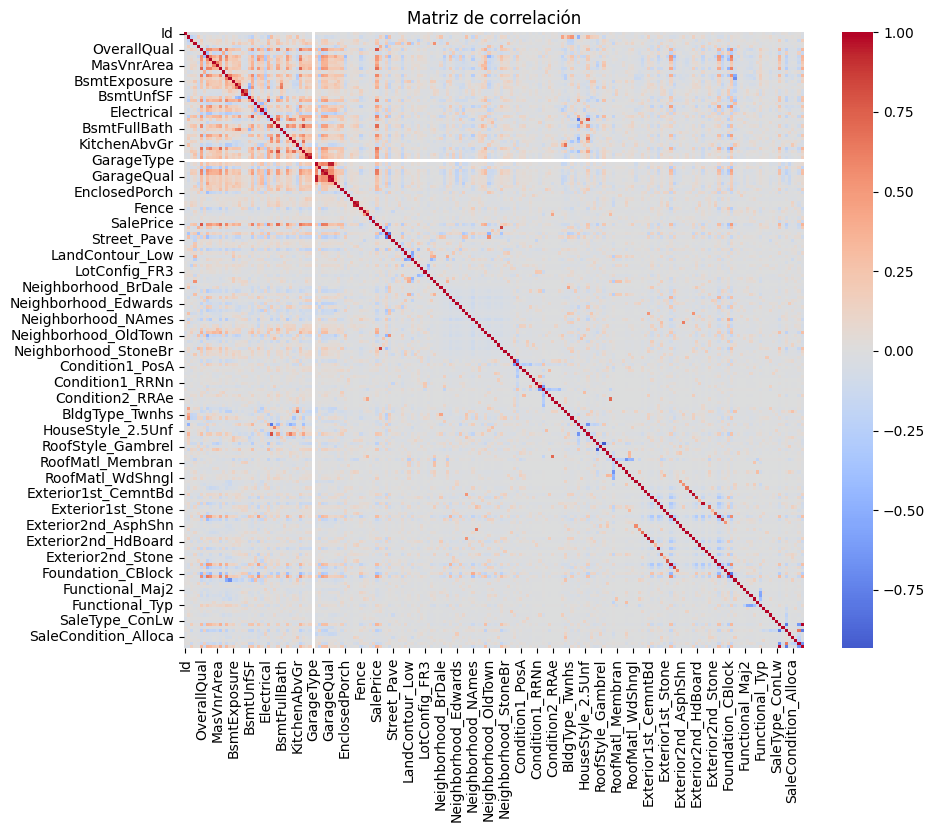

In [221]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.show()

Como podemos ver, siguen haabiendo muchas variables poco relaccionadas. Realizamos un EDA rápido con las variables que tienen correlaccion mayora 50% con SalePrice

#EDA

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual',
       'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual',
       'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd'],
      dtype='object')


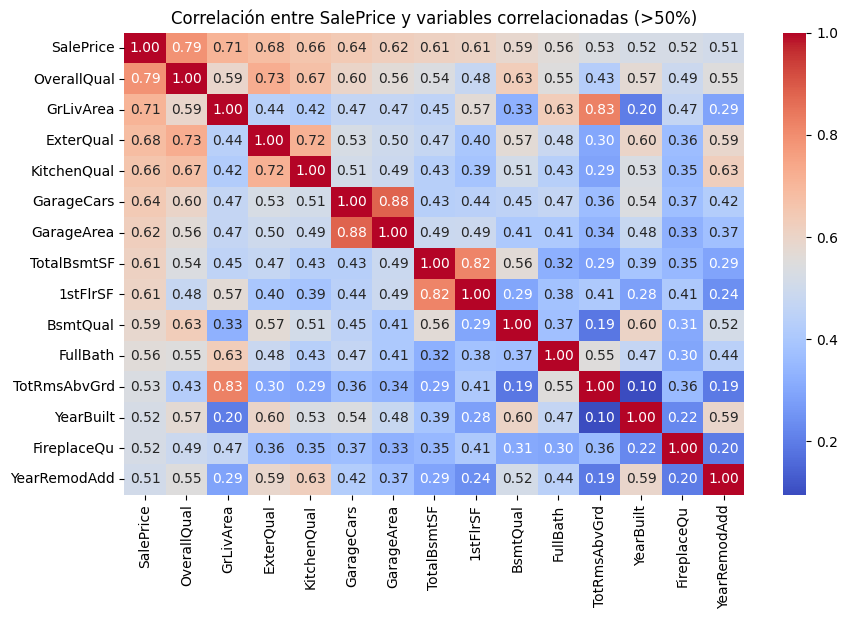

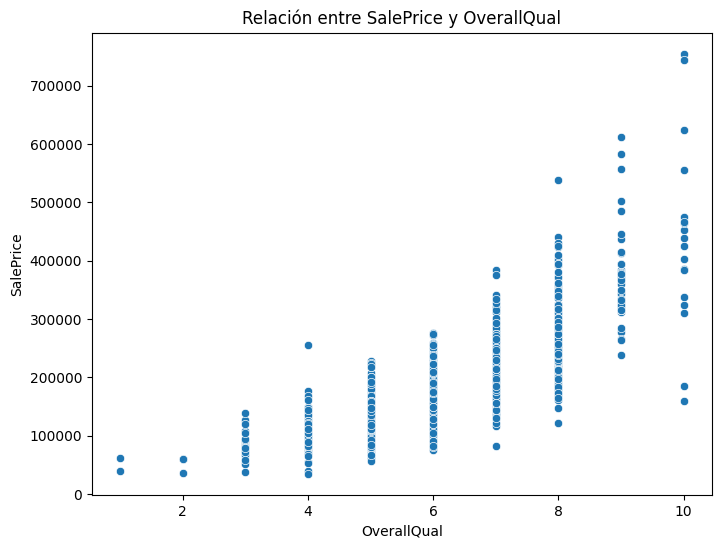

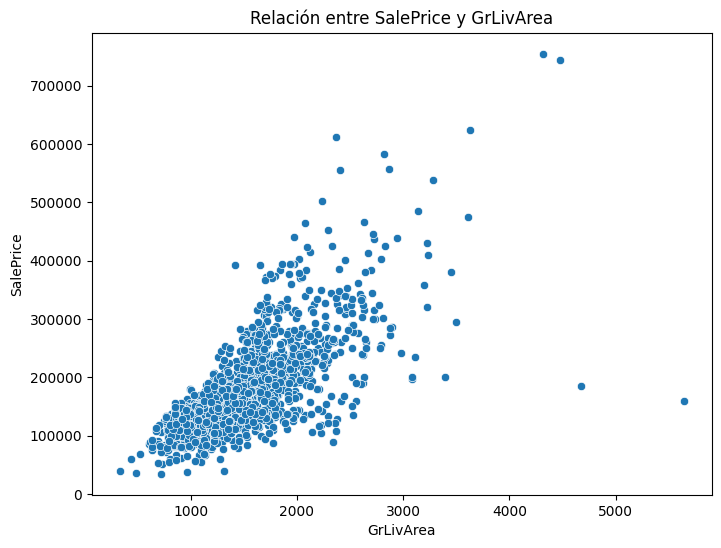

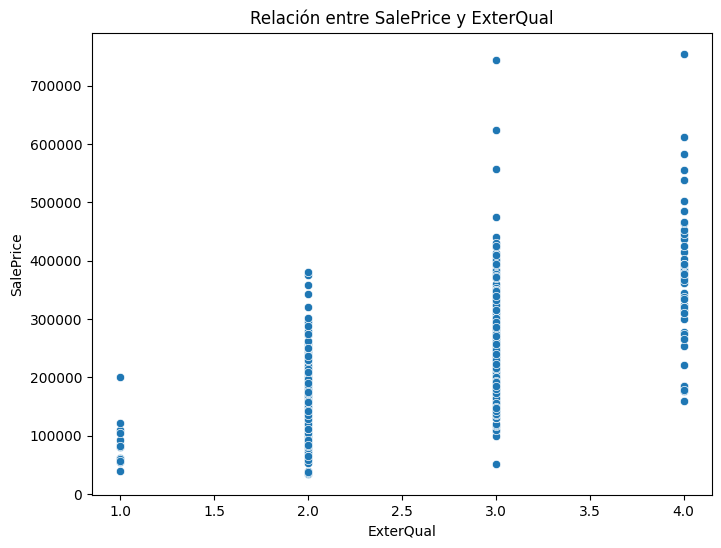

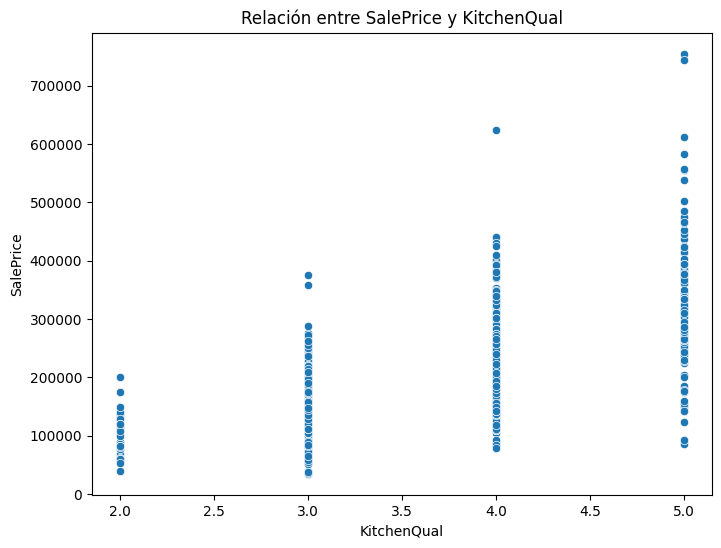

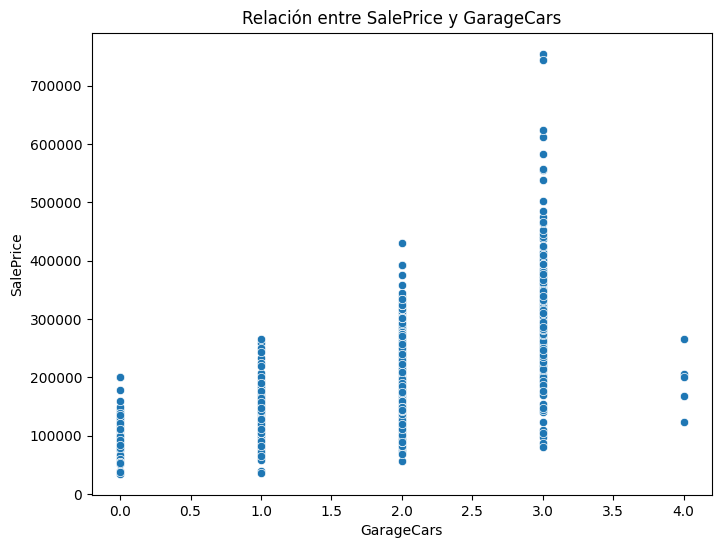

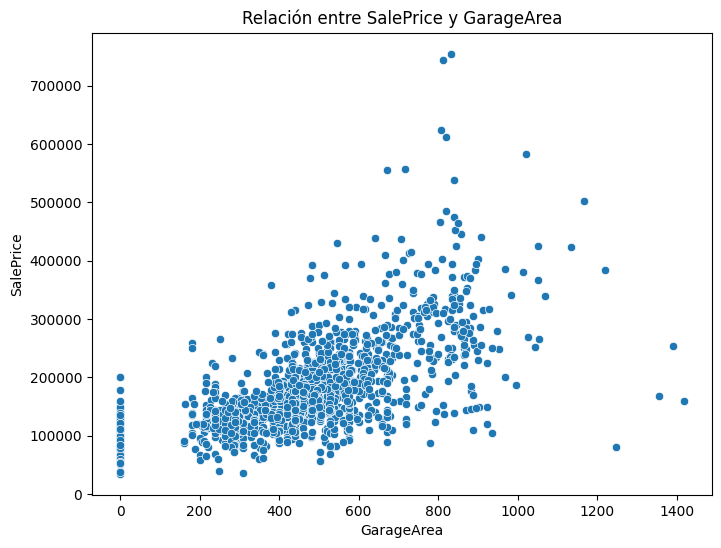

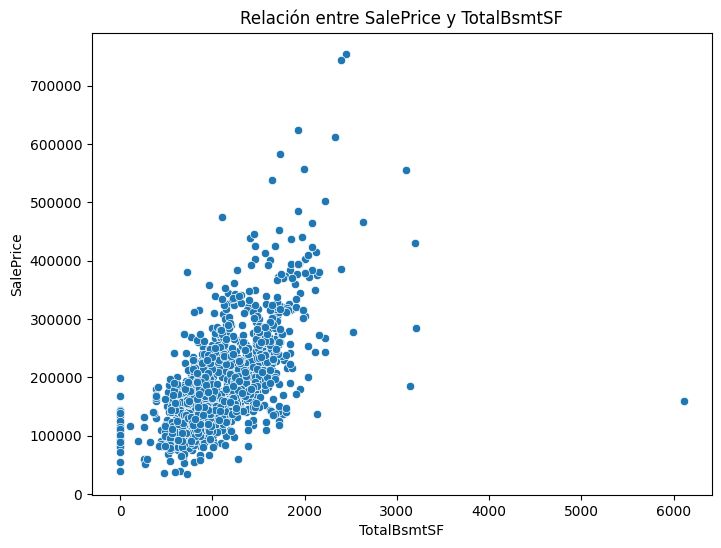

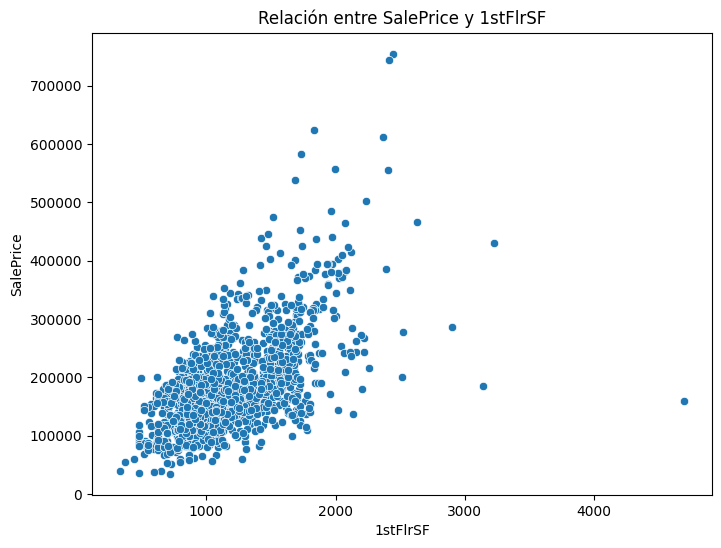

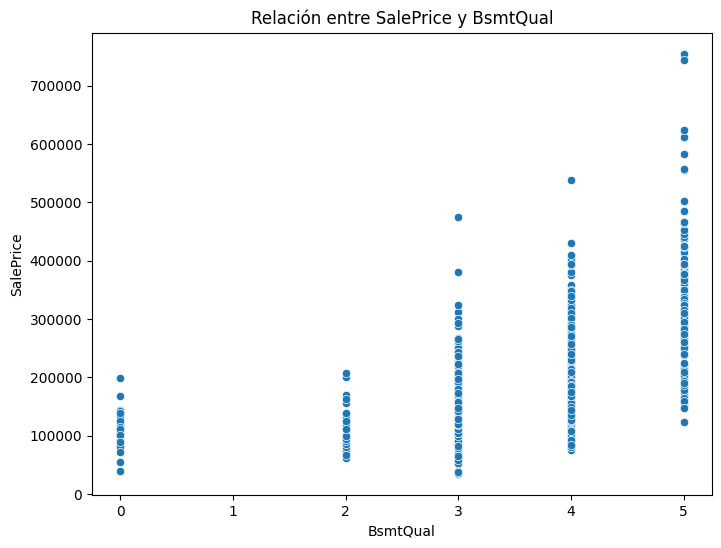

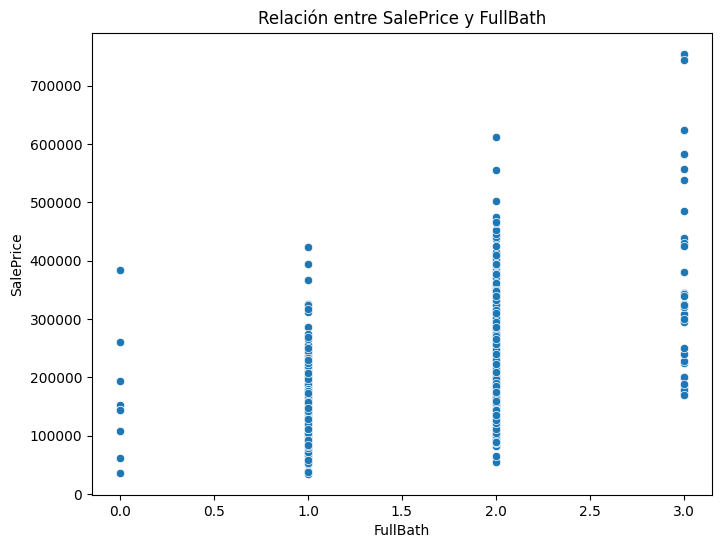

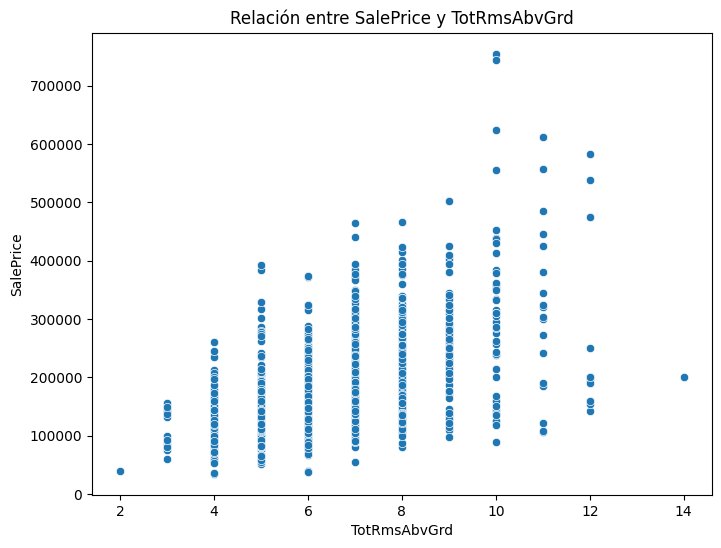

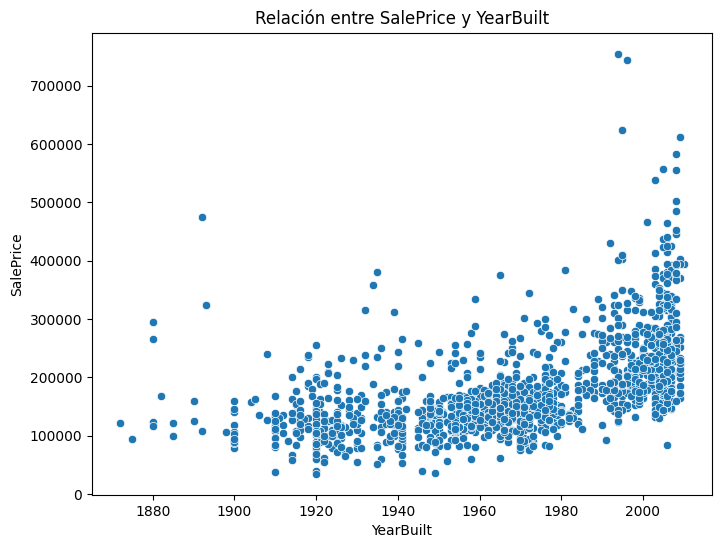

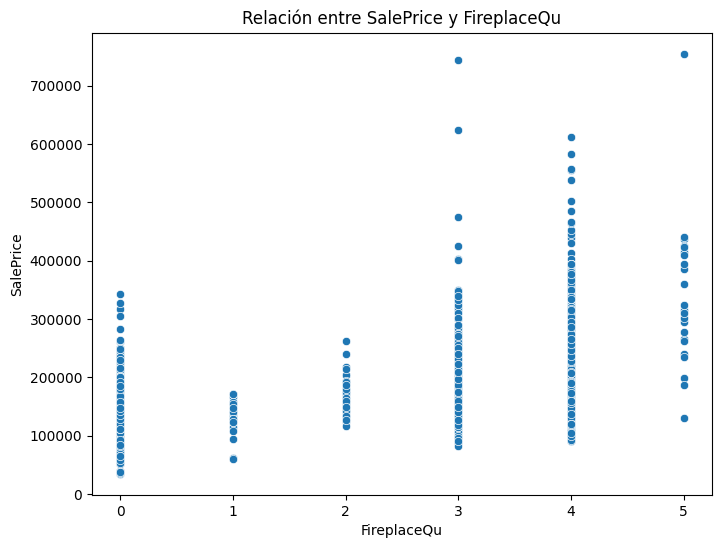

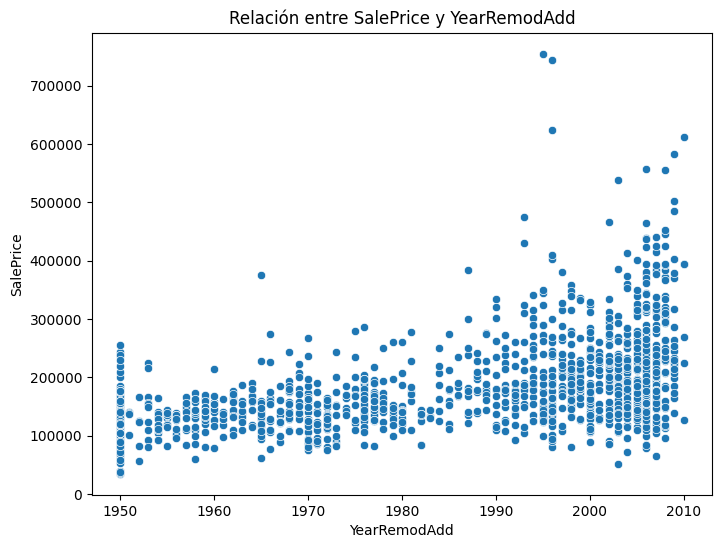

In [222]:
# Filtrar las variables con correlación mayor al 50% con 'SalePrice'
correlated_features = saleprice_corr[saleprice_corr.abs() > 0.5].index

# Mostrar las variables correlacionadas con 'SalePrice'
print(correlated_features)

# Visualizar la matriz de correlación entre 'SalePrice' y las variables correlacionadas
plt.figure(figsize=(10, 6))
sns.heatmap(data[correlated_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre SalePrice y variables correlacionadas (>50%)')
plt.show()

# Graficar las relaciones entre SalePrice y las variables correlacionadas
for feature in correlated_features:
    if feature != 'SalePrice':  # Excluir 'SalePrice' de la gráfica de dispersión
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=data[feature], y=data['SalePrice'])
        plt.title(f'Relación entre SalePrice y {feature}')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

In [223]:
# Separar la variable objetivo (SalePrice)
X = data.drop(columns=['SalePrice'])  # Variables predictoras
y = data['SalePrice']  # Variable objetivo (SalePrice)


Para hacer la base de datos un poco mas ligera, estandarizaremos, y eliminaremos las variables con  una correlaccion menor a 1% con Saleforce, asi como variables altamente correlaccionadas entre si.

In [224]:
# 1. Estandarizar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  
X = pd.DataFrame(X_scaled, columns=X.columns)  # Convertir de nuevo a DataFrame


In [225]:
# 2. Eliminar variables con baja correlación con SalePrice
correlation = X.join(y).corr(numeric_only=True)["SalePrice"].drop("SalePrice")

threshold = 0.01  # Ajusta según sea necesario
selected_features = correlation[abs(correlation) > threshold].index

X = X[selected_features]  # Mantener solo las columnas relevantes

print(f"Columnas eliminadas por baja correlación con SalePrice: {list(X.columns.difference(selected_features))}")
print(f"Nuevas dimensiones de X después de eliminar baja correlación: {X.shape}")


Columnas eliminadas por baja correlación con SalePrice: []
Nuevas dimensiones de X después de eliminar baja correlación: (1460, 182)


In [226]:
# 3. Calcular la matriz de correlación de las variables predictoras
corr_matrix = X.corr().abs()

# 4. Crear un triángulo superior de la matriz de correlación
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 5. Encontrar las columnas altamente correlacionadas (> 0.9)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# 6. Eliminar esas columnas
X = X.drop(columns=to_drop)

print(f"Dimensiones del conjunto de datos después de eliminar variables correlacionadas: {X.shape}")

Dimensiones del conjunto de datos después de eliminar variables correlacionadas: (1460, 176)


In [227]:
# Calcular correlaciones
correlation_matrix = X.corr(numeric_only=True)  # Excluye variables categóricas
saleprice_corr = X.join(y).corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

# Mostrar las más correlacionadas
print(saleprice_corr)

SalePrice            1.000000
OverallQual          0.790982
GrLivArea            0.708624
ExterQual            0.682639
KitchenQual          0.659600
                       ...   
SaleType_WD         -0.242598
LotShape_Reg        -0.267672
MSZoning_RM         -0.288065
GarageFinish        -0.292483
Foundation_CBlock   -0.343263
Name: SalePrice, Length: 177, dtype: float64


Volvemos a juntar Saleprice con nuestro base de adatos

In [228]:
X['SalePrice'] = y

Finalemnte Guardamos nuestra base de datos en ../data/finales/

In [229]:
# Guardar el dataframe preprocesado en un archivo CSV
X.to_csv('../data/finales/finales_data.csv', index=False)